In [1]:
import sys
import time
import random
import datetime
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from IPython.display import clear_output
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras import mixed_precision

from utils.plot_utils import plot_iou_trainId, plot_iou_catId
from utils.data_utils import get_labels, parse_record, get_dataset_from_tfrecord
from models.hrnet_seg_gn_v2 import HRNet
# from models.hrnet_seg import HRNet

from data_loader import DataLoader
from train_utils import TrainAccumilator
from custom_callbacks import ReduceLROnPlateau

K.clear_session()
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

def enable_amp():
    mixed_precision.set_global_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
print(physical_devices,"\n")
enable_amp() 

Tensorflow version:  2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
fine = True

img_height = 512
img_width = 1024
n_classes = 20
BATCH_SIZE = 1
ACCUM_STEPS = 6
ADJ_BATCH_SIZE = BATCH_SIZE * ACCUM_STEPS
BUFFER_SIZE = 600

labels = get_labels()
trainid2label = { label.trainId : label for label in labels }
catid2label = { label.categoryId : label for label in labels }

pipeline = DataLoader(img_height=img_height, img_width=img_width, n_classes=n_classes, sparse=True)

In [3]:
if fine:
    train_tfrecord_dir = "records/trainIds_train.record"
    test_tfrecord_dir = "records/trainIds_val.record"
    TRAIN_LENGTH = 2975
    TEST_LENGTH = 500
    train_ds = get_dataset_from_tfrecord(train_tfrecord_dir)
    test_ds = get_dataset_from_tfrecord(test_tfrecord_dir)
else:
    train_tfrecord_dir = "records/trainIds_train_extra.record"
    TRAIN_LENGTH = 18000
    TEST_LENGTH = 1998
    all_ds = get_dataset_from_tfrecord(train_tfrecord_dir)
    train_ds = all_ds.skip(TEST_LENGTH)
    test_ds = all_ds.take(TEST_LENGTH) 


train = train_ds.map(pipeline.load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_ds.map(pipeline.load_image_test)
eval = test_ds.map(pipeline.load_image_eval)

train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [4]:
def label_to_rgb(mask):
    h = mask.shape[0]
    w = mask.shape[1]
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for val, key in trainid2label.items():
        indices = mask == val
        mask_rgb[indices.squeeze()] = key.color 
    return mask_rgb


def display(display_list, title=True):
    plt.figure(figsize=(15, 5), dpi=150) # dpi=200
    if title:
        title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        if title:
            plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

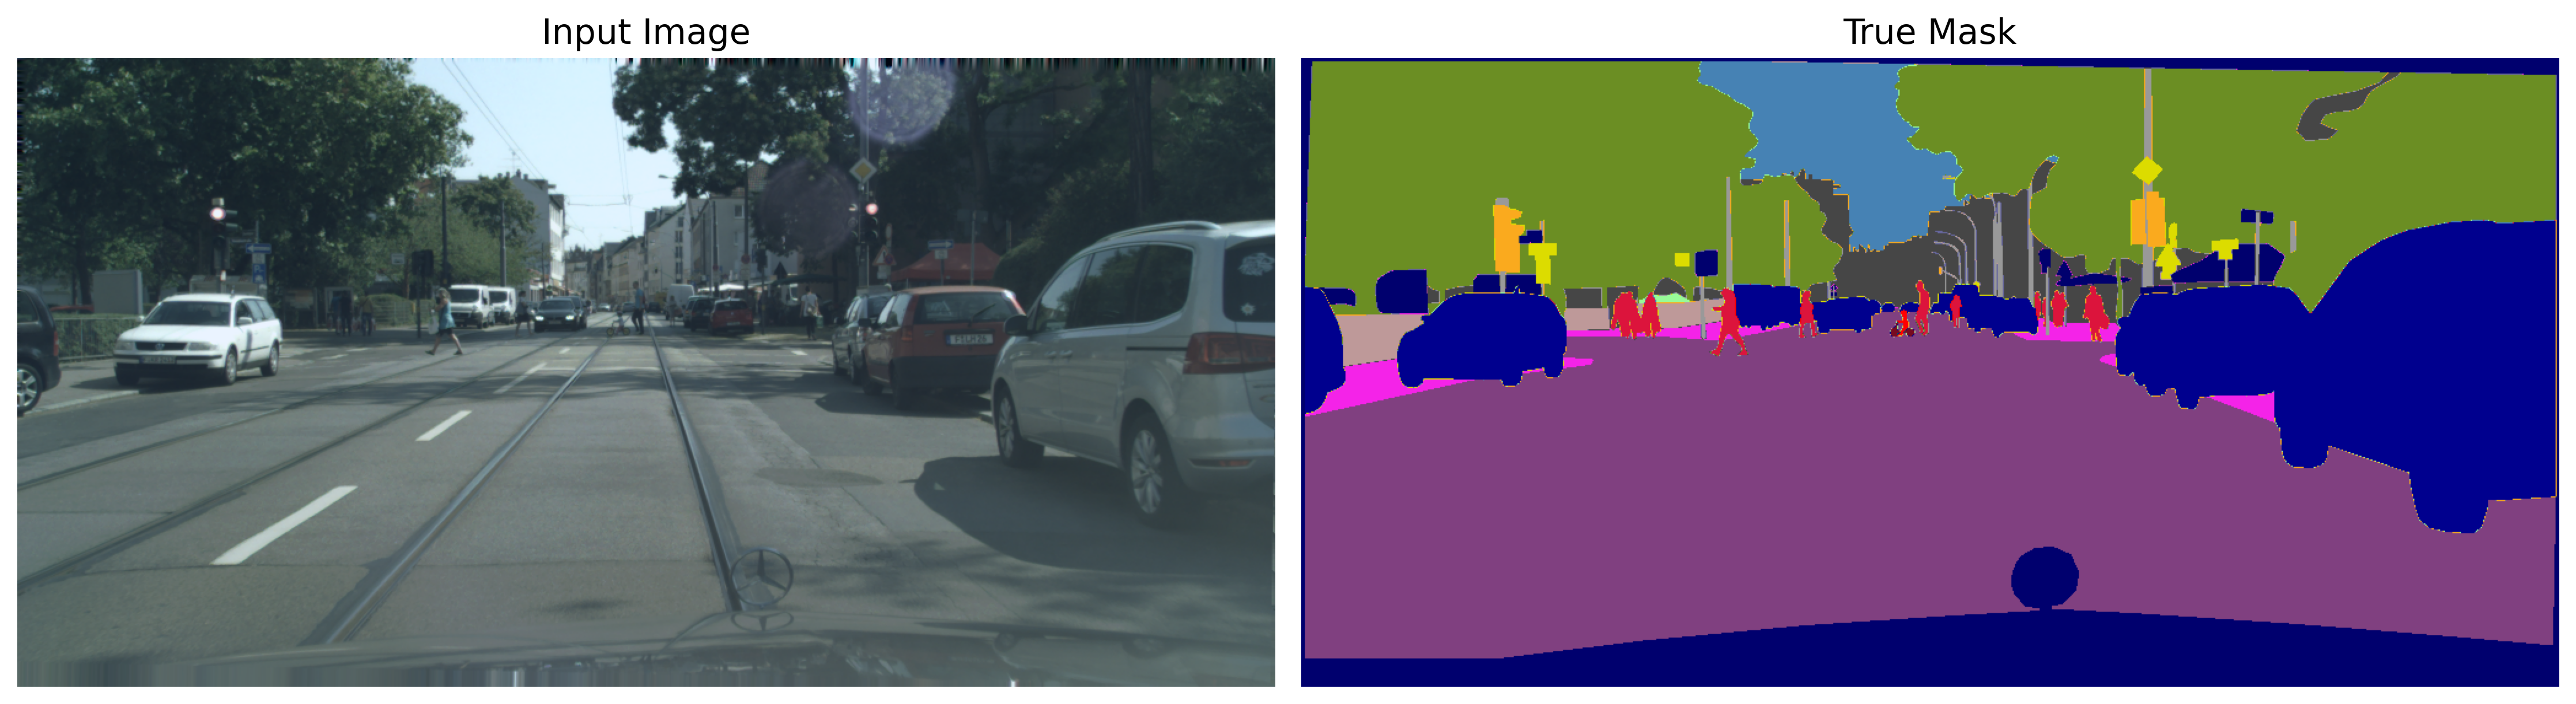

In [5]:
for image, mask in test.take(4): # 16
    sample_image, sample_mask = image, mask

if pipeline.sparse == False:
    sample_mask = tf.argmax(sample_mask, axis=-1)
sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())
display([sample_image, sample_mask])

In [6]:
# K.clear_session()

In [7]:
model = HRNet(
    stage1_cfg = {'NUM_MODULES': 1,'NUM_BRANCHES': 1,'BLOCK': 'BOTTLENECK','NUM_BLOCKS': [4]}, 
    stage2_cfg = {'NUM_MODULES': 1,'NUM_BRANCHES': 2,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4]},
    stage3_cfg = {'NUM_MODULES': 4,'NUM_BRANCHES': 3,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4, 4]},
    stage4_cfg = {'NUM_MODULES': 3,'NUM_BRANCHES': 4,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4, 4, 4]},
    input_height = img_height, 
    input_width = img_width, 
    n_classes = n_classes, 
    W = 32
)

In [8]:
model.summary()

Model: "HRNet_GN_W32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1728      
_________________________________________________________________
group_normalization (GroupNo multiple                  128       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36864     
_________________________________________________________________
group_normalization_1 (Group multiple                  128       
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
sequential_1 (Sequential)    (1, 128, 256, 128)        77568     
_________________________________________________________________
sequential_2 (Sequential)    (1, 128, 256, 32)        

In [12]:
if fine:
    MODEL_PATH = "weights/"+model.name+".h5"
else:
    MODEL_PATH = "weights/"+model.name+"_coarse.h5"

# model.load_weights("weights/"+model.name+"_coarse.h5")
model.load_weights(MODEL_PATH)

In [13]:
def create_mask(pred_mask):
    pred_mask = tf.squeeze(pred_mask)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = label_to_rgb(pred_mask.numpy())
    return pred_mask


def show_predictions():        
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    if "U2Net" in model.name:
        pred_mask = pred_mask[0]
    display([sample_image, sample_mask, create_mask(pred_mask)])

        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

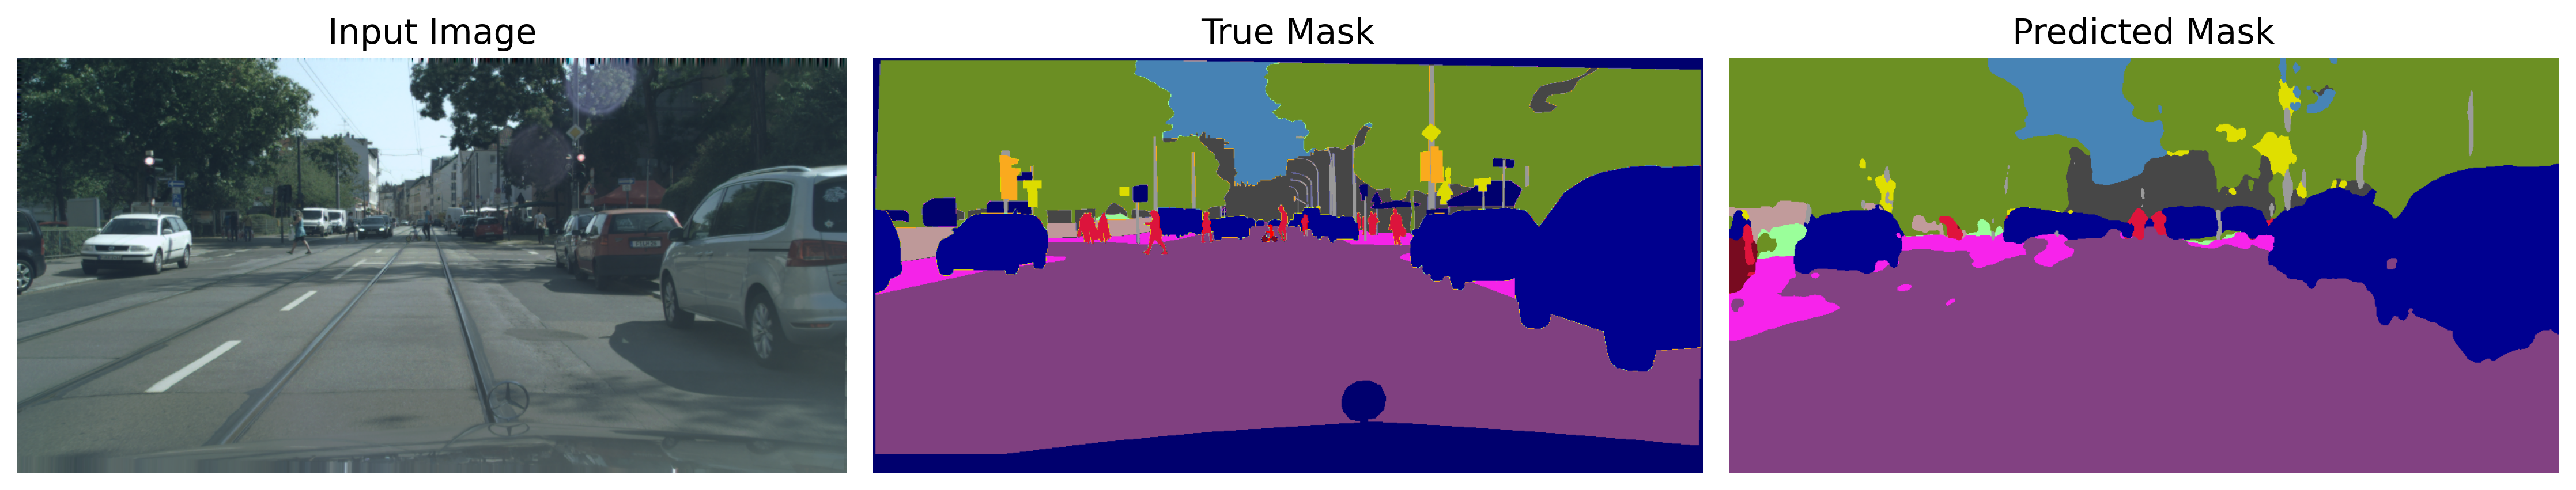

In [14]:
show_predictions()

In [15]:
! nvidia-smi

Mon May 17 16:51:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 207...  Off  | 00000000:08:00.0  On |                  N/A |
| 52%   65C    P2    55W / 215W |   5743MiB /  7948MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
EPOCHS = 200

STEPS_PER_EPOCH = TRAIN_LENGTH // ADJ_BATCH_SIZE
DECAY_STEPS = STEPS_PER_EPOCH * EPOCHS
DECAY_STEPS 

99000

In [18]:
learning_rate_fn = PolynomialDecay(
    initial_learning_rate = 0.005,
    decay_steps = DECAY_STEPS,
    end_learning_rate=5e-6,
    power=0.9
)

In [19]:
def weighted_cross_entropy_loss(y_true_labels, y_pred_logits):
    c_weights = [0.0,    2.602,  6.707,  3.522,  9.877, 
                 9.685,  9.398,  10.288, 9.969,  4.336, 
                 9.454,  7.617,  9.405,  10.359, 6.373, 
                 10.231, 10.262, 10.264, 10.394, 10.094] 
    
    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true_labels, logits=y_pred_logits)  
    weights = tf.gather(c_weights, y_true_labels)  
    losses = tf.multiply(losses, weights)
    return tf.math.reduce_mean(losses)

In [20]:
opt = SGD(learning_rate=learning_rate_fn, momentum=0.9, decay=0.0005)
# opt = Adam(learning_rate=1e-3)

trainer = TrainAccumilator(
    model = model,
    optimizer = mixed_precision.LossScaleOptimizer(opt),
    loss_fn = weighted_cross_entropy_loss,
    n_classes = n_classes,
    reduce_lr_on_plateau = None,
    accum_steps = ACCUM_STEPS,
)

In [21]:
results = trainer.fit(
    epochs = EPOCHS,
    train_dataset = train_dataset,
    test_dataset = test_dataset, 
    weights_path = MODEL_PATH
)

2975it [14:54,  3.32it/s]



Epoch 1 - loss: 3.1881 , accuracy: 0.7745, miou: 0.2808, val_loss: 3.0648, val_accuracy: 0.7240, val_miou: 0.2711, lr: 0.0039899927


2975it [14:12,  3.49it/s]



Epoch 2 - loss: 2.9389 , accuracy: 0.7893, miou: 0.3040, val_loss: 2.5301, val_accuracy: 0.7547, val_miou: 0.3101, lr: 0.0033143964


2975it [14:14,  3.48it/s]



Epoch 3 - loss: 2.7346 , accuracy: 0.7971, miou: 0.3270, val_loss: 2.5721, val_accuracy: 0.7542, val_miou: 0.3213, lr: 0.0028307121


2975it [14:13,  3.48it/s]



Epoch 4 - loss: 2.6191 , accuracy: 0.8037, miou: 0.3379, val_loss: 2.5776, val_accuracy: 0.7517, val_miou: 0.3130, lr: 0.0024673364


2975it [14:14,  3.48it/s]



Epoch 5 - loss: 2.5110 , accuracy: 0.8080, miou: 0.3529, val_loss: 2.4989, val_accuracy: 0.7499, val_miou: 0.3175, lr: 0.0021843445


2975it [14:19,  3.46it/s]



Epoch 6 - loss: 2.4558 , accuracy: 0.8109, miou: 0.3642, val_loss: 2.3545, val_accuracy: 0.7596, val_miou: 0.3403, lr: 0.0019577183


2975it [14:17,  3.47it/s]



Epoch 7 - loss: 2.3904 , accuracy: 0.8147, miou: 0.3694, val_loss: 2.2830, val_accuracy: 0.7651, val_miou: 0.3485, lr: 0.0017721421


2975it [14:13,  3.48it/s]



Epoch 8 - loss: 2.2990 , accuracy: 0.8171, miou: 0.3794, val_loss: 2.3476, val_accuracy: 0.7642, val_miou: 0.3288, lr: 0.0016173874


2975it [14:14,  3.48it/s]



Epoch 9 - loss: 2.2907 , accuracy: 0.8194, miou: 0.3783, val_loss: 2.2252, val_accuracy: 0.7678, val_miou: 0.3640, lr: 0.0014863637


2975it [14:14,  3.48it/s]



Epoch 10 - loss: 2.2075 , accuracy: 0.8227, miou: 0.3972, val_loss: 2.1347, val_accuracy: 0.7752, val_miou: 0.3833, lr: 0.0013740007


2975it [14:13,  3.48it/s]



Epoch 11 - loss: 2.2051 , accuracy: 0.8244, miou: 0.3966, val_loss: 2.2295, val_accuracy: 0.7707, val_miou: 0.3601, lr: 0.0012765756


2975it [14:13,  3.49it/s]



Epoch 12 - loss: 2.1083 , accuracy: 0.8271, miou: 0.4112, val_loss: 2.0713, val_accuracy: 0.7743, val_miou: 0.3759, lr: 0.0011912953


2975it [14:15,  3.48it/s]



Epoch 13 - loss: 2.1066 , accuracy: 0.8279, miou: 0.4151, val_loss: 2.0819, val_accuracy: 0.7707, val_miou: 0.3856, lr: 0.0011160211


2975it [14:14,  3.48it/s]



Epoch 14 - loss: 2.0221 , accuracy: 0.8310, miou: 0.4255, val_loss: 2.0669, val_accuracy: 0.7739, val_miou: 0.3919, lr: 0.0010490894


2975it [14:15,  3.48it/s]



Epoch 15 - loss: 2.0208 , accuracy: 0.8316, miou: 0.4301, val_loss: 2.0368, val_accuracy: 0.7768, val_miou: 0.4021, lr: 0.0009891855


2975it [14:15,  3.48it/s]



Epoch 16 - loss: 2.0162 , accuracy: 0.8322, miou: 0.4295, val_loss: 2.0175, val_accuracy: 0.7796, val_miou: 0.4005, lr: 0.0009352575


2975it [14:14,  3.48it/s]



Epoch 17 - loss: 1.9805 , accuracy: 0.8357, miou: 0.4413, val_loss: 2.0066, val_accuracy: 0.7789, val_miou: 0.3993, lr: 0.0008864533


2975it [14:14,  3.48it/s]



Epoch 18 - loss: 1.9669 , accuracy: 0.8336, miou: 0.4364, val_loss: 2.0155, val_accuracy: 0.7769, val_miou: 0.4052, lr: 0.0008420753


2975it [14:15,  3.48it/s]



Epoch 19 - loss: 1.9574 , accuracy: 0.8349, miou: 0.4369, val_loss: 1.9773, val_accuracy: 0.7779, val_miou: 0.4106, lr: 0.0008015474


2975it [14:14,  3.48it/s]



Epoch 20 - loss: 1.9200 , accuracy: 0.8359, miou: 0.4486, val_loss: 1.9775, val_accuracy: 0.7801, val_miou: 0.4009, lr: 0.0007643890


2975it [14:32,  3.41it/s]



Epoch 21 - loss: 1.9047 , accuracy: 0.8366, miou: 0.4537, val_loss: 1.9399, val_accuracy: 0.7826, val_miou: 0.4142, lr: 0.0007301965


2975it [14:47,  3.35it/s]



Epoch 22 - loss: 1.8866 , accuracy: 0.8367, miou: 0.4524, val_loss: 1.9280, val_accuracy: 0.7842, val_miou: 0.4236, lr: 0.0006986282


2975it [14:47,  3.35it/s]



Epoch 23 - loss: 1.8494 , accuracy: 0.8395, miou: 0.4554, val_loss: 1.9332, val_accuracy: 0.7820, val_miou: 0.4131, lr: 0.0006693928


2975it [14:47,  3.35it/s]



Epoch 24 - loss: 1.8546 , accuracy: 0.8402, miou: 0.4680, val_loss: 1.9279, val_accuracy: 0.7836, val_miou: 0.4141, lr: 0.0006422408


2975it [14:46,  3.35it/s]



Epoch 25 - loss: 1.8556 , accuracy: 0.8400, miou: 0.4636, val_loss: 1.8835, val_accuracy: 0.7856, val_miou: 0.4229, lr: 0.0006169569


2975it [14:47,  3.35it/s]



Epoch 26 - loss: 1.8214 , accuracy: 0.8407, miou: 0.4664, val_loss: 1.9159, val_accuracy: 0.7845, val_miou: 0.4205, lr: 0.0005933545


2975it [14:47,  3.35it/s]



Epoch 27 - loss: 1.8048 , accuracy: 0.8425, miou: 0.4708, val_loss: 1.8792, val_accuracy: 0.7858, val_miou: 0.4193, lr: 0.0005712713


2975it [14:48,  3.35it/s]



Epoch 28 - loss: 1.7746 , accuracy: 0.8438, miou: 0.4803, val_loss: 1.8678, val_accuracy: 0.7845, val_miou: 0.4231, lr: 0.0005505649


2975it [14:46,  3.35it/s]



Epoch 29 - loss: 1.7813 , accuracy: 0.8421, miou: 0.4733, val_loss: 1.8755, val_accuracy: 0.7869, val_miou: 0.4244, lr: 0.0005311103


2975it [14:48,  3.35it/s]



Epoch 30 - loss: 1.7717 , accuracy: 0.8442, miou: 0.4731, val_loss: 1.8892, val_accuracy: 0.7825, val_miou: 0.4297, lr: 0.0005127970


2975it [14:47,  3.35it/s]



Epoch 31 - loss: 1.7575 , accuracy: 0.8438, miou: 0.4769, val_loss: 1.8747, val_accuracy: 0.7877, val_miou: 0.4326, lr: 0.0004955275


2975it [14:46,  3.36it/s]



Epoch 32 - loss: 1.7488 , accuracy: 0.8437, miou: 0.4875, val_loss: 1.8559, val_accuracy: 0.7850, val_miou: 0.4280, lr: 0.0004792149


2975it [14:47,  3.35it/s]



Epoch 33 - loss: 1.7283 , accuracy: 0.8456, miou: 0.4879, val_loss: 1.8989, val_accuracy: 0.7850, val_miou: 0.4333, lr: 0.0004637814


2975it [14:46,  3.36it/s]



Epoch 34 - loss: 1.7495 , accuracy: 0.8446, miou: 0.4820, val_loss: 1.8400, val_accuracy: 0.7867, val_miou: 0.4266, lr: 0.0004491581


2975it [14:45,  3.36it/s]



Epoch 35 - loss: 1.6988 , accuracy: 0.8467, miou: 0.4935, val_loss: 1.8046, val_accuracy: 0.7869, val_miou: 0.4344, lr: 0.0004352824


2975it [14:45,  3.36it/s]



Epoch 36 - loss: 1.7198 , accuracy: 0.8455, miou: 0.4881, val_loss: 1.8323, val_accuracy: 0.7868, val_miou: 0.4409, lr: 0.0004220984


2975it [14:46,  3.35it/s]



Epoch 37 - loss: 1.6888 , accuracy: 0.8475, miou: 0.4968, val_loss: 1.8320, val_accuracy: 0.7857, val_miou: 0.4284, lr: 0.0004095555


2975it [14:45,  3.36it/s]



Epoch 38 - loss: 1.6896 , accuracy: 0.8462, miou: 0.4997, val_loss: 1.8262, val_accuracy: 0.7859, val_miou: 0.4309, lr: 0.0003976080


2975it [14:45,  3.36it/s]



Epoch 39 - loss: 1.6745 , accuracy: 0.8483, miou: 0.5026, val_loss: 1.8348, val_accuracy: 0.7842, val_miou: 0.4278, lr: 0.0003862143


2975it [14:46,  3.35it/s]



Epoch 40 - loss: 1.6776 , accuracy: 0.8484, miou: 0.4958, val_loss: 1.8155, val_accuracy: 0.7882, val_miou: 0.4378, lr: 0.0003753367


2975it [14:19,  3.46it/s]



Epoch 41 - loss: 1.6704 , accuracy: 0.8489, miou: 0.5086, val_loss: 1.8457, val_accuracy: 0.7857, val_miou: 0.4380, lr: 0.0003649408


2975it [14:13,  3.49it/s]



Epoch 42 - loss: 1.6429 , accuracy: 0.8486, miou: 0.5043, val_loss: 1.7857, val_accuracy: 0.7885, val_miou: 0.4361, lr: 0.0003549953


2975it [14:13,  3.48it/s]



Epoch 43 - loss: 1.6528 , accuracy: 0.8492, miou: 0.5079, val_loss: 1.7801, val_accuracy: 0.7916, val_miou: 0.4364, lr: 0.0003454714


2975it [14:11,  3.49it/s]



Epoch 44 - loss: 1.6170 , accuracy: 0.8507, miou: 0.5107, val_loss: 1.7651, val_accuracy: 0.7898, val_miou: 0.4434, lr: 0.0003363428


2975it [14:12,  3.49it/s]



Epoch 45 - loss: 1.6426 , accuracy: 0.8479, miou: 0.5098, val_loss: 1.7663, val_accuracy: 0.7904, val_miou: 0.4391, lr: 0.0003275851


2975it [14:13,  3.49it/s]



Epoch 46 - loss: 1.6521 , accuracy: 0.8503, miou: 0.5050, val_loss: 1.7620, val_accuracy: 0.7920, val_miou: 0.4508, lr: 0.0003191764


2975it [14:12,  3.49it/s]



Epoch 47 - loss: 1.6253 , accuracy: 0.8493, miou: 0.5135, val_loss: 1.7690, val_accuracy: 0.7912, val_miou: 0.4430, lr: 0.0003110959


2975it [14:12,  3.49it/s]



Epoch 48 - loss: 1.6312 , accuracy: 0.8507, miou: 0.5218, val_loss: 1.7650, val_accuracy: 0.7899, val_miou: 0.4370, lr: 0.0003033249


2975it [14:13,  3.49it/s]



Epoch 49 - loss: 1.5820 , accuracy: 0.8521, miou: 0.5231, val_loss: 1.7659, val_accuracy: 0.7921, val_miou: 0.4536, lr: 0.0002958457


1697it [08:20,  3.39it/s]


KeyboardInterrupt: 

In [22]:
results = trainer.history

In [23]:
def plot_history(results, model):
         
    plt.figure(figsize=(15,7))
    plt.subplot(1,3,1)  

    plt.plot(results['loss'], 'r', label='Training loss')
    plt.plot(results['val_loss'], 'b', label='Validation loss')
    plt.title("Loss: "+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,2)
    plt.plot(results['accuracy'], 'r', label='Training accuracy')
    plt.plot(results['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Accuracy: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,3)
    plt.plot(results['miou'], 'r', label='IoU coefficient')
    plt.plot(results['val_miou'], 'b', label='Validation IoU coefficient')
    plt.title('IoU Coefficient: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})
    if fine:
        plt.savefig("plots/"+model.name+"_learning_curves.png")
    else:
        plt.savefig("plots/"+model.name+"_learning_curves_coarse.png")
    plt.show()

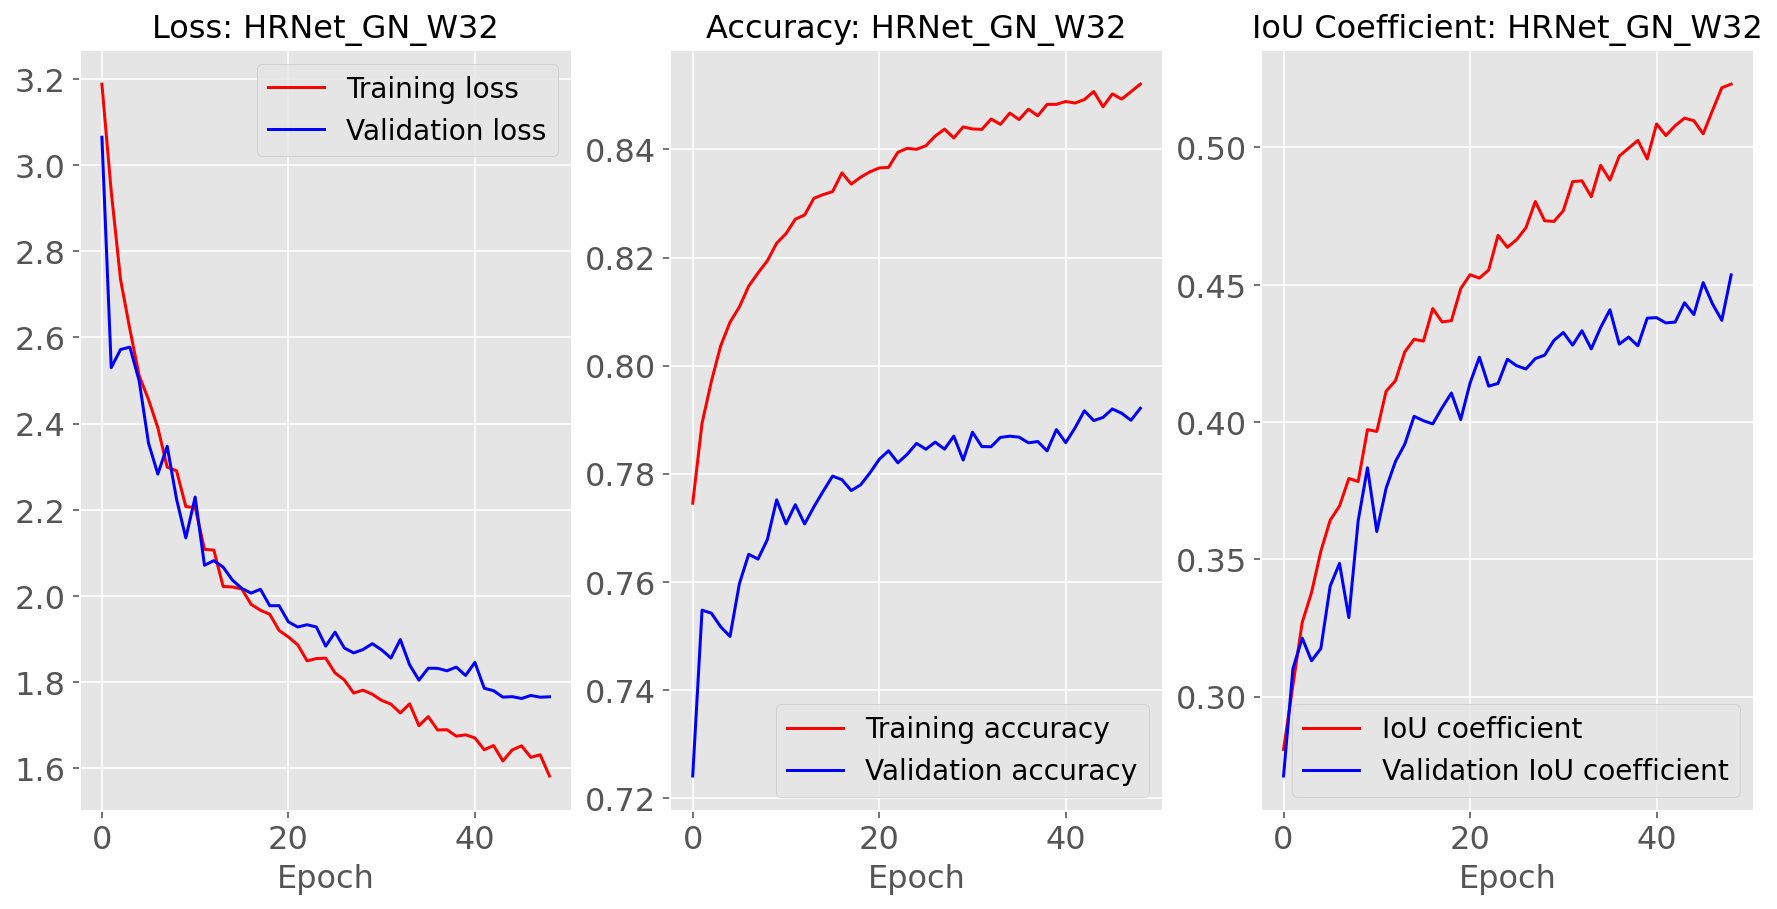

In [24]:
plot_history(results, model)

### Evaluation


In [25]:
# K.clear_session()
# model = U2NET(input_height=img_height, input_width=img_width, n_classes=20)
# model = ERFNet(input_height=img_height, input_width=img_width, n_classes=20)

In [ ]:
# model.load_weights("weights/U2Net_latest.h5")
# model.load_weights("weights/ERFNet.h5")

In [ ]:
model.load_weights(MODEL_PATH)

In [ ]:
def evaluate_iou(model, dataset, n_samples):
    
    inf_times = np.zeros((n_samples, ))
    miou_op =  tf.keras.metrics.MeanIoU(num_classes=n_classes-1)
    
    for idx, (image, mask) in enumerate(dataset):
        print("\r Predicting {} \ {} ".format(idx+1, n_samples), end='')
        
        X = np.expand_dims(image.numpy(), axis=0)
        y_true = np.expand_dims(mask.numpy(), axis=0)
        
        t_start = time.time()
        y_pred = model.predict(X)
        t_end = time.time()
        t_inf = t_end-t_start
        
        inf_times[idx] = t_inf
        
        if "U2Net" in model.name:
            y_pred = y_pred[0]
            
        y_pred = tf.image.resize(y_pred, (1024, 2048))
        threshold = tf.math.reduce_max(y_pred, axis=-1, keepdims=True)
        y_pred = tf.logical_and(y_pred >= threshold, tf.abs(y_pred) > 1e-12)
        
        y_pred = tf.cast(tf.squeeze(y_pred, axis=0), tf.int32)
        y_true = tf.cast(tf.squeeze(y_true, axis=0), tf.int32)
        
        if pipeline.sparse == False:
            y_true = tf.argmax(y_true[:,:,1:], axis=-1)
        else:
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), n_classes)
            y_true = tf.argmax(y_true[:,:,1:], axis=-1)
        y_pred = tf.argmax(y_pred[:,:,1:], axis=-1)
                
        miou_op.update_state(y_true, y_pred)
        
        if idx == (n_samples-1):
            break
    
    print("Average inference time: {:.2f}s".format(np.mean(inf_times)))
            
    return miou_op

In [ ]:
miou_op = evaluate_iou(model=model, dataset=eval, n_samples=TEST_LENGTH)
iou_mean = miou_op.result().numpy()

In [ ]:
union_int = np.sum(miou_op.get_weights()[0], axis=0)+np.sum(miou_op.get_weights()[0], axis=1)
inters = np.diag(miou_op.get_weights()[0])
ious = inters / (union_int-inters+1)

In [ ]:
plot_iou_trainId(
    trainId_label_map=trainid2label,
    catId_label_map=catid2label, 
    n_classes=n_classes, 
    iou_class=ious,
    model=model, 
    iou_mean=iou_mean,
)

In [ ]:
def visualize_confusion_matrix(confusion, metric, label_classes, model):
    plt.figure(figsize=(14,14))
    plt.title("{} Confusion Matrix, with Mean IoU = {:.3f}".format(model.name, metric), fontsize=22)
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    # set horizontal alignment mode (left, right or center) and rotation mode(anchor or default)
    plt.setp(ax.get_xticklabels(), rotation=-90, ha="center", rotation_mode="default")
    # avoid top and bottom part of heatmap been cut
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.grid(False)
    fig.tight_layout()
    plt.show()

In [ ]:
visualize_confusion_matrix(
    confusion = miou_op.get_weights()[0] / np.sum(miou_op.get_weights()[0], axis=0), 
    metric = iou_mean, 
    label_classes = [trainid2label[i].name for i in range(1, n_classes)],
    model = model
)

In [ ]:
def show_predictions(sample_image, sample_mask):        
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    if "U2Net" in model.name:
        pred_mask = pred_mask[0]
    # sample_mask = tf.argmax(sample_mask, axis=-1)
    sample_mask = sample_mask[..., tf.newaxis]
    sample_mask = label_to_rgb(sample_mask.numpy())
    display([sample_image, sample_mask, create_mask(pred_mask)])

In [ ]:
for image, mask in test.take(96): # 16
    sample_image, sample_mask = image, mask
show_predictions(sample_image, sample_mask)

In [ ]:
for image, mask in test.take(4): # 16
    sample_image, sample_mask = image, mask
show_predictions(sample_image, sample_mask)

In [ ]:
for image, mask in test.take(27): # 16
    sample_image, sample_mask = image, mask
show_predictions(sample_image, sample_mask)